In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from utility import analysis_parameters as ap
from utility import util
import numpy as np
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

var="iwc"
model="ARP"
topdown=False # False for NICAM and SAM and UM; all else True

chunk_dict = {"time":80,"lat":32, "lon":32, "Xdim":1000, "ncol":1000, "rgrid":1000}
diff=False
lev=0

colors=ap.COLORS
plt.rcParams['font.size']=16

In [2]:
# plt.rcParams

# Calculate the cloud top heights

In [3]:
ds = xr.open_dataset(ap.get_file(model, "TWP_3D", var), chunks=chunk_dict)[var]
if model=="GEOS" or model=="SCREAM" or model=="ICON" or model=="SHiELD"or model=="UM" or model=="ARP":
    z = xr.open_dataset(ap.get_file(model, "TWP_3D", "zg"), chunks=chunk_dict).zg
    print(z[0,:,0].values)
elif model=="SAM":
    z = ds.z
    print(z[0].values)
elif model=="NICAM":
    z = ds.lev
    print(z[0].values)
if model=="GEOS":
    ds = ds[::3]
    z = z[::3]
    print(z[0].values)
    print(ds.time.values[0], z[0].time.values)
elif model=="UM":
    z = z.sel(time=ds.time)
elif model=="ARP":
    ds = ds.sel(lev=z.lev)
print(ds.shape, z.shape)
ds

[########################################] | 100% Completed | 202.64 ms
[20987.63     19942.885    19001.494    18188.133    17491.174
 16890.99     16363.735    15888.217    15453.802    15052.874
 14679.154    14326.161    13987.119    13655.795    13326.76
 12995.133    12656.577    12307.53     11945.293    11567.853
 11173.97     10763.592    10337.68      9897.918     9446.352
  8985.416     8517.973     8047.0957    7575.97      7107.5225
  6644.6807    6190.489     5747.7363    5318.9385    4905.8647
  4510.5356    4134.6035    3778.8093    3443.521     3128.55
  2833.654     2558.4124    2301.7744    2061.8562    1836.2106
  1621.8346    1418.1416    1228.301     1054.0112     894.5136
   749.14294    617.23737    498.30212    391.98395    297.91876
   215.80621    145.41296     86.54228     39.034824]
(232, 59, 202950) (232, 59, 202950)


<xarray.DataArray 'iwc' (time: 232, lev: 59, rgrid: 202950)>
dask.array<getitem, shape=(232, 59, 202950), dtype=float32, chunksize=(80, 59, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28
    clon     (rgrid) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    clat     (rgrid) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * lev      (lev) float64 17.0 18.0 19.0 20.0 21.0 ... 71.0 72.0 73.0 74.0 75.0
Dimensions without coordinates: rgrid
Attributes:
    standard_name:  air_pressure
    long_name:      Pressure
    units:          kg/m3
    param:          0.3.0
    CDI_grid_type:  unstructured
    origin:         pres

In [4]:
z[0,:,0].values

[########################################] | 100% Completed | 100.74 ms


array([20987.63    , 19942.885   , 19001.494   , 18188.133   ,
       17491.174   , 16890.99    , 16363.735   , 15888.217   ,
       15453.802   , 15052.874   , 14679.154   , 14326.161   ,
       13987.119   , 13655.795   , 13326.76    , 12995.133   ,
       12656.577   , 12307.53    , 11945.293   , 11567.853   ,
       11173.97    , 10763.592   , 10337.68    ,  9897.918   ,
        9446.352   ,  8985.416   ,  8517.973   ,  8047.0957  ,
        7575.97    ,  7107.5225  ,  6644.6807  ,  6190.489   ,
        5747.7363  ,  5318.9385  ,  4905.8647  ,  4510.5356  ,
        4134.6035  ,  3778.8093  ,  3443.521   ,  3128.55    ,
        2833.654   ,  2558.4124  ,  2301.7744  ,  2061.8562  ,
        1836.2106  ,  1621.8346  ,  1418.1416  ,  1228.301   ,
        1054.0112  ,   894.5136  ,   749.14294 ,   617.23737 ,
         498.30212 ,   391.98395 ,   297.91876 ,   215.80621 ,
         145.41296 ,    86.54228 ,    39.034824], dtype=float32)

In [5]:
thres=1e-6

#initialize arrays to zeros
cldtop = np.zeros(ds[:,0].shape)
cldtopind = np.zeros(ds[:,0].shape)
print("shapes", cldtop.shape, cldtopind.shape, ds.shape, z.shape)

if model=="SAM":
    for l in range(1,len(ds.z)):
        print(-l, z[-l].values)
        cldtop = np.where((cldtop==0)&(ds.isel(z=-l)>thres), z[-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(z=-l)>thres), -l, cldtopind)
elif model=="UM":
    for l in range(1,len(ds.model_level_number)):
        print(-l, z[0,-l,0,0].values, "m")
        cldtop = np.where((cldtop==0)&(ds.isel(model_level_number=-l)>thres), z[:,-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(model_level_number=-l)>thres), -l, cldtopind)
elif model=="ICON":
    for l in range(18,len(ds.height)-1):
        print(l, z[0,l,0].values, "m")
        cldtop = np.where((cldtop==0)&(ds.isel(height=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(height=l)>thres), l, cldtopind)
elif model=="SCREAM":
    for l in range(21,len(ds.lev)-1):
        print(l, z[0,l,0].values, "m")
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="ARP":
    for l in range(1,len(ds.lev)-1):
        print(l, z[0,l,0].values, "m")
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="GEOS":
    for l in range(75,len(ds.lev)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=l)>thres), l, cldtopind)
elif model=="SHiELD":
    for l in range(10,len(ds.pfull_ref)-1):
        print(l, z[0,l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(pfull_ref=l)>thres), z[:,l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(pfull_ref=l)>thres), l, cldtopind)
elif model=="NICAM": #NICAM
    for l in range(1,len(ds.lev)-1):
        print(-l, z[0,-l,0].values)
        cldtop = np.where((cldtop==0)&(ds.isel(lev=-l)>thres), z[:,-l], cldtop)
        cldtopind = np.where((cldtopind==0)&(ds.isel(lev=-l)>thres), -l, cldtopind)
else:
    raise Exception("model not defined")

shapes (232, 202950) (232, 202950) (232, 59, 202950) (232, 59, 202950)
[########################################] | 100% Completed | 100.85 ms
1 19942.885 m
[########################################] | 100% Completed | 22.57 s
[########################################] | 100% Completed | 4.13 ss
[########################################] | 100% Completed | 18.15 s
[########################################] | 100% Completed | 101.32 ms
2 19001.494 m
[########################################] | 100% Completed | 9.69 ss
[########################################] | 100% Completed | 2.12 ss
[########################################] | 100% Completed | 9.87 ss
[########################################] | 100% Completed | 101.35 ms
3 18188.133 m
[########################################] | 100% Completed | 9.57 ss
[########################################] | 100% Completed | 2.82 ss
[########################################] | 100% Completed | 9.57 ss
[########################################

In [6]:
cldtop.shape, thres

((232, 202950), 1e-06)

In [7]:
cldtop.mean()

6291.386493984642

In [8]:
if model=="GEOS" or model=="SHiELD":
    da = xr.DataArray(cldtop, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","Xdim"], coords={"time":ds.time,"Xdim":ds.Xdim}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="SCREAM":
    da = xr.DataArray(cldtop, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","ncol"], coords={"time":ds.time,"ncol":ds.ncol}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="ICON":
    da = xr.DataArray(cldtop, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","cell"], coords={"time":ds.time,"cell":ds.cell}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="UM":
    da = xr.DataArray(cldtop, dims=["time","latitude","longitude"], 
                      coords={"time":ds.time,"latitutde":ds.latitude,"longitude":ds.longitude}, 
                      attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","latitude","longitude"], 
                         coords={"time":ds.time,"latitutde":ds.latitude,"longitude":ds.longitude},  
                         attrs={"name":"cloud top height index","units":"index","thres":thres})
elif model=="ARP":
    da = xr.DataArray(cldtop, dims=["time","rgrid"], coords={"time":ds.time,"rgrid":ds.rgrid}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","rgrid"], coords={"time":ds.time,"rgrid":ds.rgrid}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})
else: # SAM
    da = xr.DataArray(cldtop, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                  attrs={"name":"cloud top height","units":"m","thres":thres})
    daind = xr.DataArray(cldtopind, dims=["time","lat","lon"], coords={"time":ds.time,"lat":ds.lat,"lon":ds.lon}, 
                     attrs={"name":"cloud top height index","units":"index","thres":thres})

In [9]:
model

'ARP'

In [10]:
file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_iwc_20200130-20200228.nc".format(model)
try:
    ds = xr.open_dataset(file)
    ds = ds.assign({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind})
except:
    ds = xr.Dataset({"cldtop_height{:.0e}".format(thres):da, "cldtop_ind{:.0e}".format(thres):daind},
                    attrs={"name":"cloud top height", "deets":"calculated in cloudtop.ipynb from iwc"})
ds

<xarray.Dataset>
Dimensions:             (time: 232, rgrid: 202950)
Coordinates:
  * time                (time) datetime64[ns] 2020-01-30T03:00:00 ... 2020-02-28
  * rgrid               (rgrid) int64 0 1 2 3 4 ... 202946 202947 202948 202949
Data variables:
    cldtop_height1e-05  (time, rgrid) float64 ...
    cldtop_ind1e-05     (time, rgrid) float64 ...
    cldtop_height1e-07  (time, rgrid) float64 ...
    cldtop_ind1e-07     (time, rgrid) float64 ...
    cldtop_height1e-06  (time, rgrid) float64 1.636e+04 1.636e+04 ... 0.0 0.0
    cldtop_ind1e-06     (time, rgrid) float64 6.0 6.0 6.0 7.0 ... 0.0 0.0 0.0
Attributes:
    name:     cloud top height
    deets:    calculated in cloudtop.ipynb from iwc

In [11]:
ds["cldtop_height{:.0e}".format(thres)].mean()

<xarray.DataArray 'cldtop_height1e-06' ()>
array(6291.38649398)

In [12]:
file

'/work/bb1153/b380883/TWP/TWP_ARP_cldtop_height_iwc_20200130-20200228.nc'

In [13]:
# save file
try:
    ds.to_netcdf(file)
    print("saved first time")
except:
    ! rm $file
    ds.to_netcdf(file)
    print("saved after removing old file")


saved after removing old file


# Plotting cldtop height vs olr

In [31]:
# file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_20200130-20200228.nc".format(m)
# ds = xr.open_dataset(file, chunks=chunk_dict)

(3, 4)
0 GEOS
	shapes of ds and olr match: True
[########################################] | 100% Completed | 49.89 s
[########################################] | 100% Completed | 49.89 s
[########################################] | 100% Completed | 49.99 s
[########################################] | 100% Completed | 3.73 sms
[########################################] | 100% Completed | 3.74 s
[########################################] | 100% Completed | 3.83 s
23316480
[########################################] | 100% Completed | 10.78 s
[########################################] | 100% Completed | 10.88 s
[########################################] | 100% Completed | 10.88 s
[########################################] | 100% Completed | 3.83 sms
[########################################] | 100% Completed | 3.83 s
[########################################] | 100% Completed | 3.93 s
23316480
[########################################] | 100% Completed | 11.29 s
[#########################

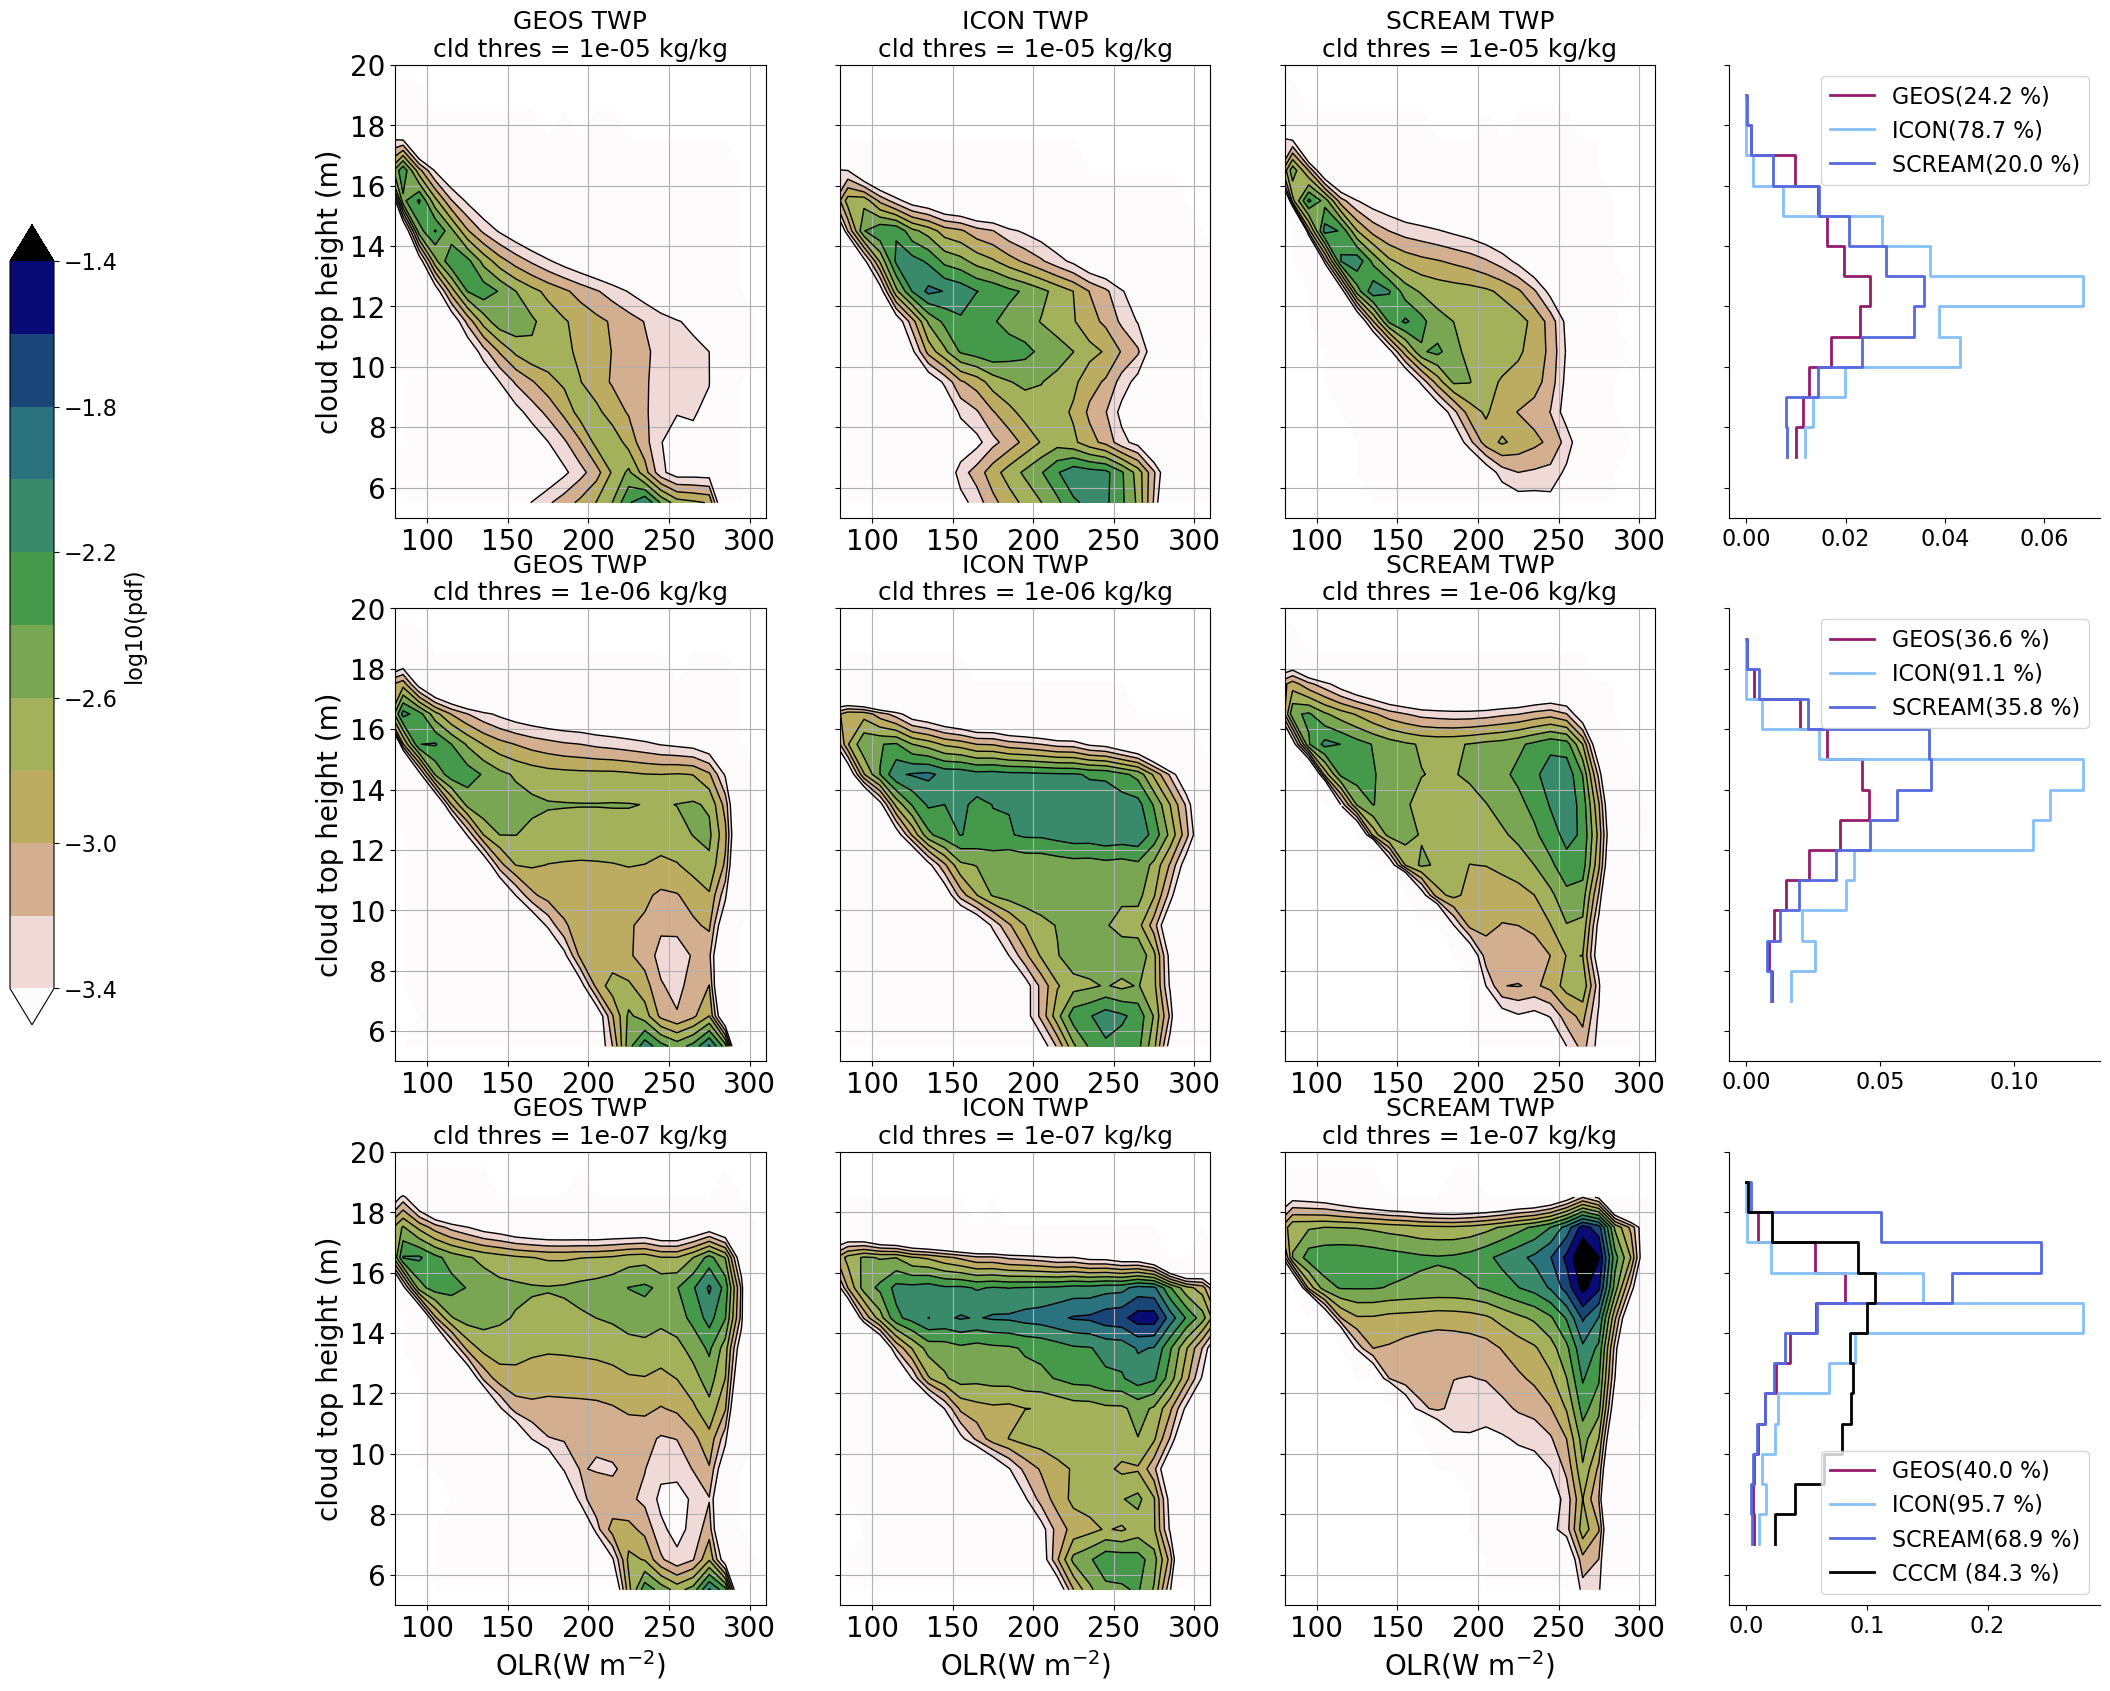

In [33]:
models=["GEOS","ICON","SCREAM"]
# models = ["GEOS"]
region="TWP"
mod_lab=""

fig, ax = plt.subplots(3,len(models)+1, figsize=(22,20), sharey=True)
print(ax.shape)
zbins = np.arange(5,20.1)

for i,m in enumerate(models):
    print(i, m)   
    file = "/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_iwc_20200130-20200228.nc".format(m)
    ds = xr.open_dataset(file, chunks=chunk_dict)

    olr = ap.load_olr(m,"TWP", r=0).sel(time=ds.time)
    print("\tshapes of ds and olr match:", ds['cldtop_height1e-05'].shape==olr.shape)
    
    # plot
    util.dennisplot("density",olr.values.flatten(), 
                    ds['cldtop_height1e-05'].values.flatten()/1000, 
                    ax=ax[0,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=zbins, colorbar_on=False, draw_line=False)
    ax[0,i].set_ylim([5,20])
    ax[0,i].set_xlim([80,310])
    ax[0,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-5), fontsize=18)
    util.dennisplot("density",olr.values.flatten(), 
                    ds['cldtop_height1e-06'].values.flatten()/1000, 
                    ax=ax[1,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=zbins, colorbar_on=False, draw_line=False)
    ax[1,i].set_ylim([5,20])
    ax[1,i].set_xlim([80,310])
    ax[1,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-6), fontsize=18)

    _, im = util.dennisplot("density",olr.values.flatten(), 
                            ds['cldtop_height1e-07'].values.flatten()/1000, 
                    ax=ax[2,i], model=m, region=region,
                    cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                    ybins=zbins, colorbar_on=False, draw_line=False)
    ax[2,i].set_ylim([5,20])
    ax[2,i].set_xlim([80,310])
    ax[2,i].set_title("{} TWP\ncld thres = {} kg/kg".format(m, 1e-7), fontsize=18)

    ax[i,0].set_ylabel("cloud top height (m)")
    ax[1,i].set_ylabel("")
    ax[2,i].set_ylabel("")

    # cth pdf on far right plot
    hist0, _ = np.histogram(ds['cldtop_height1e-05'].values.flatten()/1000, bins=zbins)
    hist0 = hist0/np.prod(np.shape(ds['cldtop_height1e-05']))
    cf = (1-np.sum(np.where(ds['cldtop_height1e-05']==0,1,0)) /
          np.prod(np.shape(ds['cldtop_height1e-05'])))*100
    ax[0,3].step(hist0[2:], zbins[2:-1], label=m+f"({cf:0.1f} %)", lw=2, 
                 where='pre', color=colors[m])
    hist1, _ = np.histogram(ds['cldtop_height1e-06'].values.flatten()/1000, bins=zbins)
    hist1 = hist1/np.prod(np.shape(ds['cldtop_height1e-06']))
    cf = (1-np.sum(np.where(ds['cldtop_height1e-06']==0,1,0)) /
          np.prod(np.shape(ds['cldtop_height1e-06'])))*100
    ax[1,3].step(hist1[2:], zbins[2:-1], label=m+f"({cf:0.1f} %)", lw=2, 
                 where='pre', color=colors[m])
    hist2, _ = np.histogram(ds['cldtop_height1e-07'].values.flatten()/1000, bins=zbins)
    hist2 = hist2/np.prod(np.shape(ds['cldtop_height1e-07']))
    cf = (1-np.sum(np.where(ds['cldtop_height1e-07']==0,1,0)) /
          np.prod(np.shape(ds['cldtop_height1e-07'])))*100
    ax[2,3].step(hist2[2:], zbins[2:-1], label=m+f"({cf:0.1f} %)", lw=2, 
                 where='pre', color=colors[m])

    mod_lab+=m[:2]

# add CCCM cldtop height distribution to bottom right plot

# olr = xr.open_dataset(ap.CCCM_JFM).CERES_LW_TOA_flux___upwards
cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height.mean(axis=1)
cth = np.where(np.isnan(cth), 0, cth)

hist, _ = np.histogram(cth, bins=zbins)
hist = hist/np.prod(np.shape(cth))
cf = (1-np.sum(np.where(cth==0,1,0)) /
          np.prod(np.shape(cth)))*100
ax[2,3].step(hist[2:], zbins[2:-1], where='pre', lw=2, color="k", label=f"CCCM ({cf:0.1f} %)")

mod_lab+="_CCCM"

for i in range(2):
    for j in range(3):
        ax[i,j].set_xlabel("")
        if i==0:
            ax[j,3].legend(loc="best")
            ax[j,3].spines[['right', 'top']].set_visible(False)
            ax[j,3].set_ylabel("")
            if j>0:
                ax[j,3].set_xlabel("")

ax[0,1].set_ylabel("")
ax[0,2].set_ylabel("")
# ax[2,3].set_xlabel("pdf")
cbar_ax = fig.add_axes([-0.05, 0.4, 0.02, 0.4])
cb = fig.colorbar(im, cax=cbar_ax, label="log10(pdf)")

print("saved as ",mod_lab)
plt.savefig("../plots/TWP/cldtopiwc_v_olr_{}.png".format(mod_lab),dpi=120,
            bbox_inches="tight", pad_inches=0.5)
plt.show()

In [13]:
# for i in [cldtop_low, cldtop_med, cldtop_hgh]:
#     print((i.where(i==0).count()/i.count()).values)


[########################################] | 100% Completed |  0.7s
0.17746782865855631
[########################################] | 100% Completed |  0.8s
0.3018176683413582
[########################################] | 100% Completed |  0.7s
0.6133990503810179


# Obs CTH vs OLR


In [8]:
model="CCCM"
region="TWP"
nlayer="mean"
olr = xr.open_dataset(ap.CCCM_JFM).CERES_LW_TOA_flux___upwards
if nlayer=="mean":
    cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height.mean(axis=1)
else:
    cth = xr.open_dataset(ap.CCCM_JFM).Mean_CALIPSO_5_km_cloud_layer_top_height[:,nlayer]
print(olr.shape, cth.shape)

(15352,) (15352,)


In [9]:
cth = np.where(np.isnan(cth), 0, cth)

15352


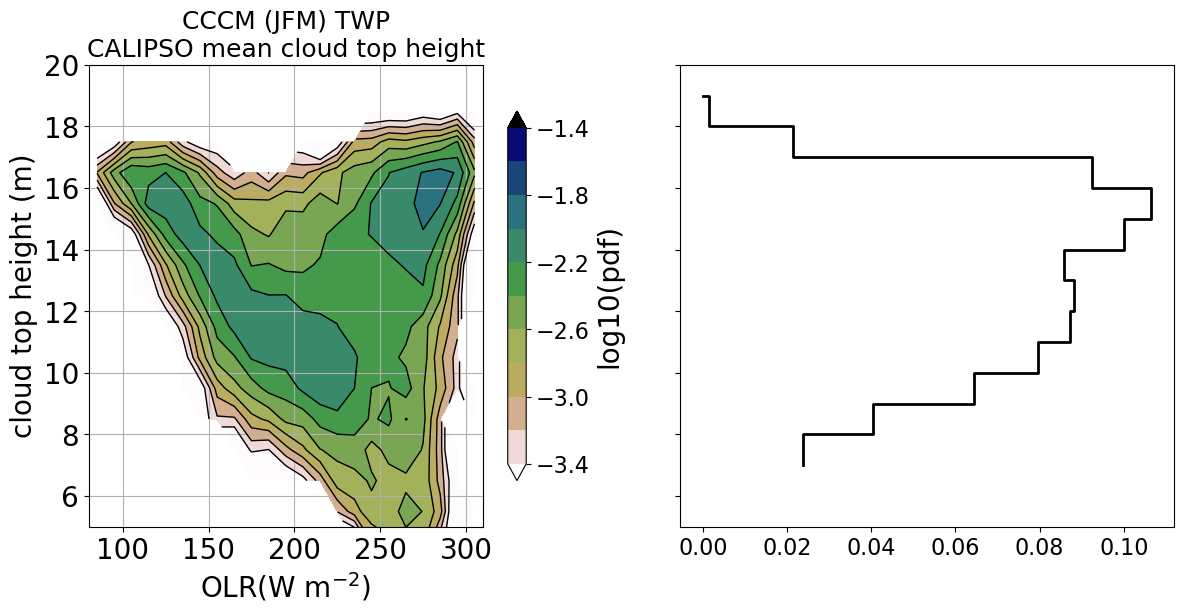

In [10]:
fig, [ax,axpdf] = plt.subplots(1,2, figsize=(14,6), sharey=True)
util.dennisplot("density",olr.values.flatten(), cth.flatten(), 
                ax=ax, model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20.1), colorbar_on=True, draw_line=False)
ax.set(ylim=[5,20], ylabel="cloud top height (m)")
ax.set_title("CCCM (JFM) TWP\nCALIPSO mean cloud top height", fontsize=18)

hist, _ = np.histogram(cth, bins=zbins)
hist = hist/np.prod(np.shape(cth))
axpdf.step(hist[2:], zbins[2:-1], where='pre', lw=2, color="k")

plt.savefig("../plots/TWP/cldtop_v_olr_CCCM_{}.png".format(nlayer))
plt.show()

# Single model CTH vs OLR

In [2]:
thres=1e-7

In [3]:
model="ARP"
thresh = "cldtop_height{:.0e}".format(thres)
region="TWP"
olr = xr.open_dataset(ap.get_file(model,var="rlt"), chunks=chunk_dict).rlt
if model=="ARP":
    olr = olr/-900
cth = xr.open_dataset("/work/bb1153/b380883/TWP/TWP_{}_cldtop_height_iwc_20200130-20200228.nc".format(model), chunks=chunk_dict)
print(cth)
cth = cth[thresh]
olr = olr.sel(time=cth.time)
# olr = olr.interp(time=cth.time, method="linear")
# print(olr.time[:5].values)
zbins = np.arange(0,21,1)

olr.shape, cth.shape, thresh

['2020-01-30T03:00:00.000000000' '2020-01-30T06:00:00.000000000'
 '2020-01-30T09:00:00.000000000' '2020-01-30T12:00:00.000000000'
 '2020-01-30T15:00:00.000000000']
['2020-01-30T03:00:00.000000000' '2020-01-30T06:00:00.000000000'
 '2020-01-30T09:00:00.000000000' '2020-01-30T12:00:00.000000000'
 '2020-01-30T15:00:00.000000000']


((232, 202950), (232, 202950), 'cldtop_height1e-07')

In [4]:
olr[:3].values, cth[:3].values

[########################################] | 100% Completed | 1.51 sms
[########################################] | 100% Completed | 1.71 ss


(array([[120.83001 , 116.492805, 113.50195 , ..., 270.75946 , 270.30872 ,
         270.14536 ],
        [132.55058 , 131.25305 , 131.04285 , ..., 264.7588  , 269.86813 ,
         271.32654 ],
        [186.15575 , 175.81854 , 165.34744 , ..., 270.91513 , 270.57516 ,
         271.01474 ]], dtype=float32),
 array([[18188.1328125 , 18188.03320312, 18187.44921875, ...,
         15881.1171875 , 15878.54199219, 15879.13964844],
        [15895.42285156, 16373.93652344, 16374.44726562, ...,
         10343.9296875 , 10342.34179688, 10342.56640625],
        [16360.57128906, 16361.39746094, 16362.00683594, ...,
          1625.05151367,  1625.05371094,  3136.50024414]]))

In [5]:
cth.mean(), olr.mean()

(<xarray.DataArray 'cldtop_height1e-07' ()>
 dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>,
 <xarray.DataArray 'rlt' ()>
 dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>)

[########################################] | 100% Completed | 4.97 sms
[########################################] | 100% Completed | 509.13 ms
47084400
[########################################] | 100% Completed | 508.42 ms
[########################################] | 100% Completed | 407.70 ms


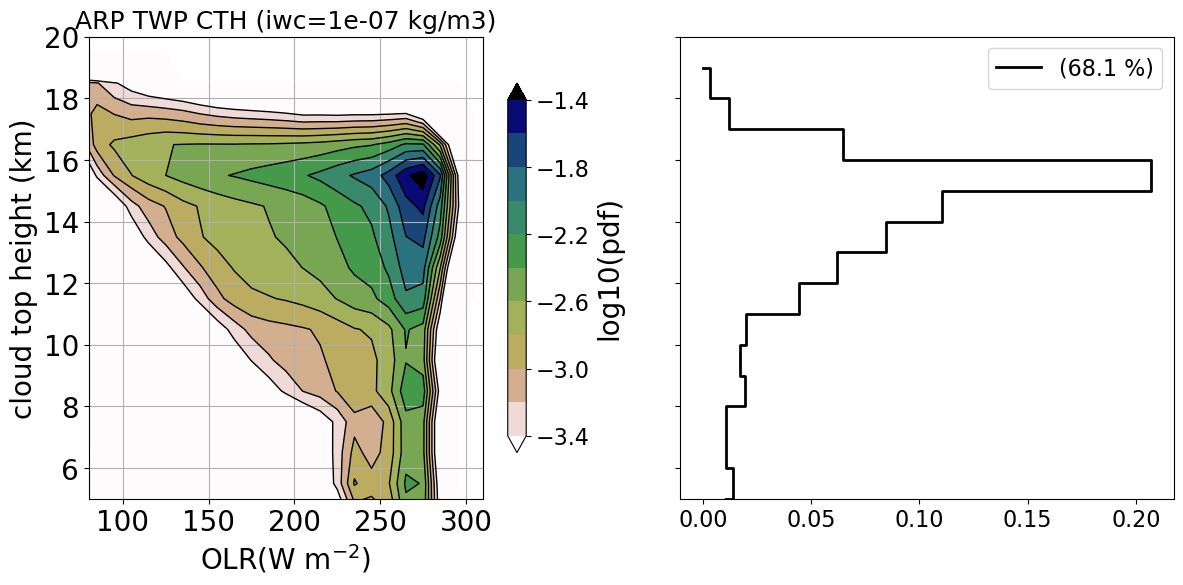

In [8]:
fig, [ax,axpdf] = plt.subplots(1,2, figsize=(14,6), sharey=True)
util.dennisplot("density",olr.values.flatten(), cth.values.flatten()/1000, 
                ax=ax, model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=zbins, colorbar_on=True, draw_line=False)
ax.set(ylim=[5,20], ylabel="cloud top height (km)")
ax.set_title(f"{model} TWP CTH (iwc={thresh.split('t')[-1]} kg/m3)", fontsize=18)

hist, _ = np.histogram(cth/1000, bins=zbins)
hist = hist/np.prod(np.shape(cth))
cf = (np.sum(np.where(cth>5000,1,0))/np.prod(np.shape(cth)))*100
axpdf.step(hist[2:], zbins[2:-1], where='pre', lw=2, color="k", label=f"({cf:0.1f} %)")
axpdf.legend()
plt.savefig("../plots/TWP/cldtop_v_olr_{}_iwcthres{}.png".format(model,thres))
plt.show()

# Single model CTH vs OLR with IWP shaded in side-by-side plot

In [14]:
iwp = ap.load_iwp(model,"TWP",total=False, chunks=chunk_dict)[::12][:-1]*1000#.sel(time=cldtop_low.time)*1000
iwp

returned ice only GEOS TWP


<xarray.DataArray 'clivi' (time: 239, Xdim: 97152)>
dask.array<mul, shape=(239, 97152), dtype=float32, chunksize=(7, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T18:00:00
    lons     (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lats     (Xdim) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: Xdim

In [15]:
print(iwp.shape, olr.shape, cldtop_low.shape)
print(iwp.time[0].values, olr.time[0].values, cldtop_low.time[0].values)
print(iwp.time[-1].values, olr.time[-1].values, cldtop_low.time[-1].values)
# olr = olr.sel(time=iwp.time)
# cldtop_low = cldtop_low.sel(time=iwp.time)

(239, 97152) (239, 97152) (239, 97152)
2020-01-30T00:00:00.000000000 2020-01-30T00:00:00.000000000 2020-01-30T00:00:00.000000000
2020-02-28T18:00:00.000000000 2020-02-28T18:00:00.000000000 2020-02-28T18:00:00.000000000


In [16]:
print(iwp.shape, olr.shape, cldtop_low.shape)

(239, 97152) (239, 97152) (239, 97152)


[########################################] | 100% Completed | 538.52 s
[########################################] | 100% Completed | 2.12 ss
23219328
[########################################] | 100% Completed | 11.78 s
[########################################] | 100% Completed | 406.46 ms
[########################################] | 100% Completed | 17.31 s


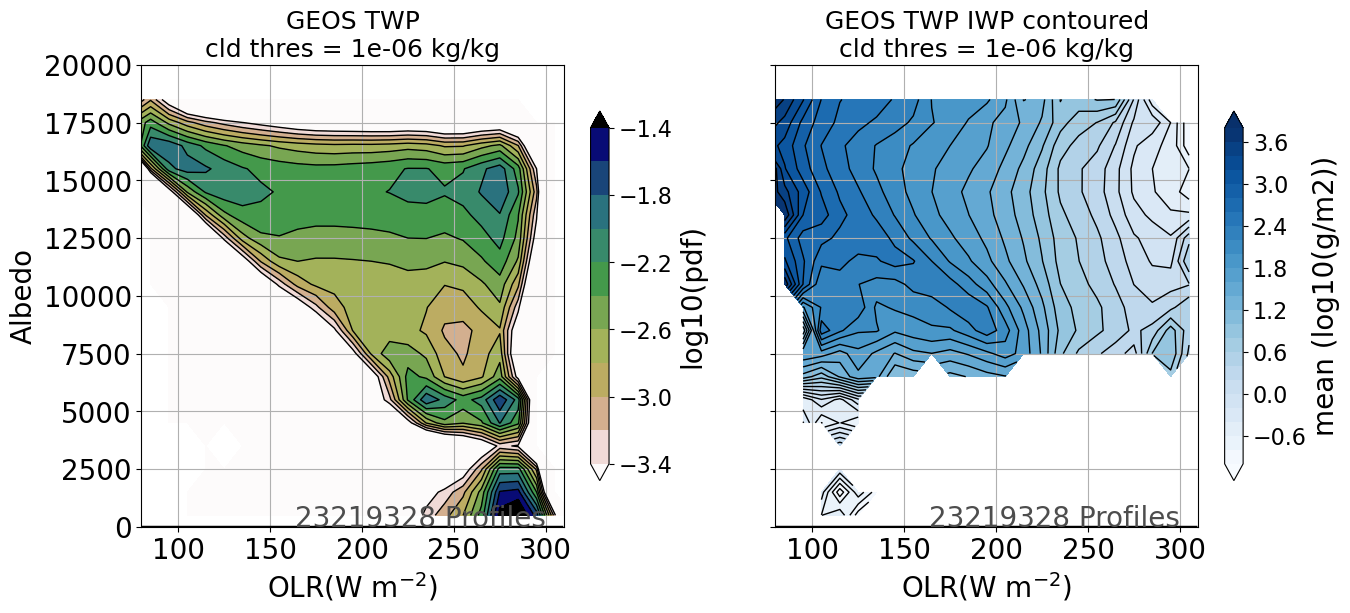

In [17]:
region="TWP"

fig, ax = plt.subplots(1,2, figsize=(15,6), sharey=True)
util.dennisplot("density",olr.values.flatten(), cldtop_low.values.flatten(), 
                ax=ax[0], model=model, region=region,
                cmap="gist_earth_r", levels=np.arange(-3.4,-1.2,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[0].set_ylim([0,20000])
ax[0].set_title("{} TWP\ncld thres = {} kg/kg".format(model, 1e-6), fontsize=18)

util.dennisplot("mean",olr.values.flatten(), cldtop_low.values.flatten(), 
                var=np.log10(iwp.values.flatten()),
                ax=ax[1], model=model, region=region,
                var_name="log10(IWP)", units="log10(g/m2)",
                cmap="Blues", levels=np.arange(-1,4,0.2), 
                ybins=np.arange(0,20000,1000), colorbar_on=True)
ax[1].set_ylim([0,20000])
ax[1].set(ylabel="")
ax[1].set_title("{} TWP IWP contoured\ncld thres = {} kg/kg".format(model, 1e-6), fontsize=18)


plt.savefig("../plots/TWP/cldtop_v_olr_iwp_{}.png".format(model),dpi=120)
plt.show()